In [ ]:
 !pip install -U classiq

In [2]:
import classiq
classiq.authenticate()

Your user code: DPLR-ZPQM
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=DPLR-ZPQM


In [20]:
!pip install lmfit
from lmfit.models import GaussianModel as lmfit_GaussianModel

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from classiq import *
from classiq.execution import ExecutionSession
from tqdm import tqdm
from scipy.linalg import norm
import itertools

# Define the 2D Hamiltonian
HAMILTONIAN = [
    PauliTerm([Pauli.I, Pauli.I], -1.0523),
    PauliTerm([Pauli.I, Pauli.Z], 0.3979),
    PauliTerm([Pauli.Z, Pauli.I], -0.3979),
    PauliTerm([Pauli.Z, Pauli.Z], -0.0112),
    PauliTerm([Pauli.X, Pauli.X], 0.1809),
]

In [4]:
def make_grafics_beautiful(xlabel, ylabel):
  fig, ax = plt.subplots(dpi=200)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()
  plt.rc('grid', linestyle=":", color='grey', alpha = 0.5)
  return fig, ax


In [ ]:
def save_qprog(qprog, file_name):
    """
    A simple function that saves your quantum program (qprog) as a text file in a .qprog format.
    The function saves the qprog in the same directory as the current Python file you are working on.

    Inputs:
        - qprog: the quantum program (the returned value of the synthesize() function)
        - file_name: a string that determines the file name
    """
    file = open(file_name + ".qprog", "w")
    file.write(qprog)
    file.close()

In [5]:
np.random.seed(0)

In [6]:
matrix_H = hamiltonian_to_matrix(HAMILTONIAN)
print("H", matrix_H)
print("E", np.linalg.eigh(matrix_H).eigenvalues)
norm = norm(matrix_H)
print("norm", norm)

[[-1.0635+0.j  0.    +0.j  0.    +0.j  0.1809+0.j]
 [ 0.    +0.j -1.8369+0.j  0.1809+0.j  0.    +0.j]
 [ 0.    +0.j  0.1809+0.j -0.2453+0.j  0.    +0.j]
 [ 0.1809+0.j  0.    +0.j  0.    +0.j -1.0635+0.j]]
2.413987870723463


In [7]:
aux_number = 6

# transform one prep_ancilla from |0...0⟩ to c*(|0...0⟩ + ... + |1...1⟩)
@qfunc
def prep_ancilla(q: QBit) -> None:
    X(target=q)
    H(target=q)

# transform initial state from |0...0⟩ to c*(|0...0⟩ + ... + |1...1⟩)
@qfunc
def prep_target(qba: QArray[QBit]):
  H(target=qba[0])
  X(target=qba[1])


# function for evolving the state over time
@qfunc
def trotter(qba: QArray[QBit], t: CReal) -> None:
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=t,
        order=1,
        repetitions=30,
        qbv=qba
        )


# aux: array of ancilla qubits
# E: energie wich we want to test, if it is the eigenvalue of the provided hamiltonian
# t: array of "times" for the phase gate
@qfunc
def main(aux: Output[QArray[QBit]], E: CReal, t: CArray[CReal, aux_number]) -> None:
  allocate(aux_number, aux)

  repeat(aux.len, lambda i: prep_ancilla(aux[i]))

  target = QArray("target")

  allocate(2, target)

  prep_target(target)

  for i in range(aux_number):
    control(aux[i], lambda: trotter(target, t[i]))

  for i in range(aux_number):
    PHASE(target = aux[i], theta=E*t[i])

  for i in range(aux_number):
    H(aux[i])

In [8]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
save_qprog(qprog, 'main_H2')

Opening: https://platform.classiq.io/circuit/64cce79e-955e-470b-8019-22e933e8ce6d?version=0.59.0


In [14]:
execution_session = ExecutionSession(qprog)

E_vals = np.linspace(-2.4, 0, 160)

In [ ]:
all_p = []
default_number_of_shots = 2048

## uncomment to generate new t
# t = list(np.random.normal(size = aux_number, scale = 9))
## fix the found results for t, as the best found parameters

t =  [-8.05919905074308, 3.482122480733358, -4.597246238119857, -10.62568965710171, -0.25364005504789383, 3.854986834773759]
for E in tqdm(E_vals):
    sample_result = execution_session.sample({"E": E, "t": t})
    counts = sample_result.counts
    states = list(counts.keys())
    shots = list(counts.values())

    # get the probability of the |1...1⟩ state of ancilla qubits
    p = [i[1]/default_number_of_shots for i in zip(states, shots) if i[0] == "1"*aux_number]
    if not p:
        p = [0]
    all_p.append(p)

print("t:", t)

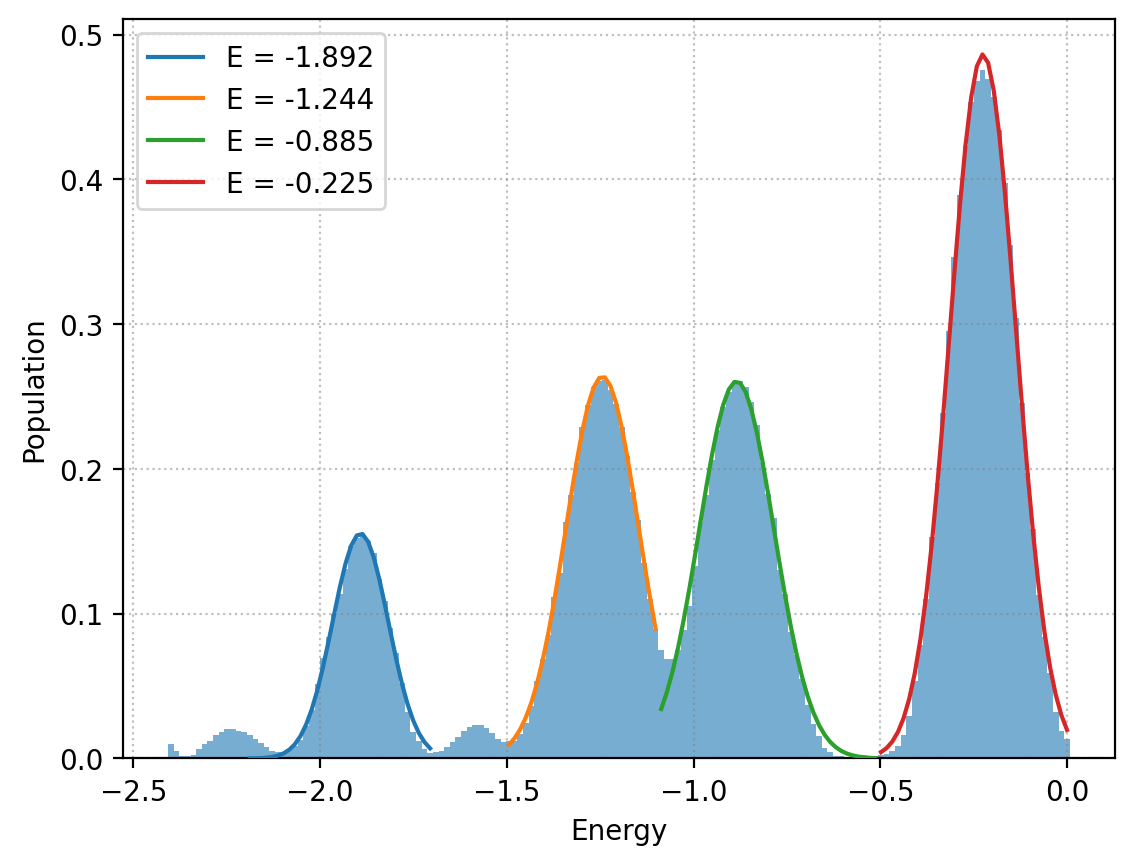

In [37]:
peak_1_E_edges = [-2.2, -1.7]
peak_2_E_edges = [-1.5, -1.1]
peak_3_E_edges = [-1.1, -0.5]
peak_4_E_edges = [-0.5, 0]
edges = [peak_1_E_edges, peak_2_E_edges, peak_3_E_edges, peak_4_E_edges]


results_peak_1 = []
results_peak_2 = []
results_peak_3 = []
results_peak_4 = []
results = [results_peak_1, results_peak_2, results_peak_3, results_peak_4]

fig, ax = make_grafics_beautiful("Energy", "Population")
delta_E = E_vals[0]-E_vals[1]

plt.bar(np.array(E_vals).flatten(), np.array(all_p).flatten(), width = delta_E, alpha = 0.6,)

for i in range(len(edges)):
    lower_edge = edges[i][0]
    upper_edge = edges[i][1]

    indices_within_edges = np.where((E_vals >= lower_edge) & (E_vals <= upper_edge))[0]

    # Get the values from array1 that are within the edges
    energies_of_peak = np.array(E_vals)[indices_within_edges]

    # Get the values from array2 at the positions of the indices
    peak = np.array(all_p)[indices_within_edges].flatten()

    gmodel = lmfit_GaussianModel()
    result = gmodel.fit(peak, x = energies_of_peak,
                                      amplitude = max(peak), center = (upper_edge+lower_edge)/2,
                                      sigma = upper_edge - lower_edge)


    obtained_from_fit_energy = result.uvars["center"].nominal_value

    plt.plot(energies_of_peak,
             result.best_fit,
             linewidth = 1.9, label = f"E = {round(obtained_from_fit_energy, 3)}", zorder = 3)


# plt.savefig('energies_spectra.pdf')
plt.legend()
plt.show()

In [ ]:
HAMILTONIAN_H2O = [
    PauliTerm([Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -12.533),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I, Pauli.I], -1.276),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.I, Pauli.I, Pauli.I, Pauli.I], 0.627),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I], -0.875),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], 0.452),
    PauliTerm([Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I, Pauli.I], 0.182),
    PauliTerm([Pauli.I, Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I], 0.139),
    PauliTerm([Pauli.Y, Pauli.Y, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -0.047),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.I], 0.209),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], -0.154),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.Z], 0.198),
    PauliTerm([Pauli.X, Pauli.I, Pauli.I, Pauli.I, Pauli.X, Pauli.I], 0.061),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Y, Pauli.I, Pauli.Y, Pauli.I], -0.027),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.Z], 0.118),
]

In [ ]:
matrix_H = hamiltonian_to_matrix(HAMILTONIAN_H2O)
print("Analytically calculated energies of H2O")
np.linalg.eigh(matrix_H).eigenvalues

array([-16.21743355, -16.05728855, -15.79952666, -15.63939701,
       -15.2472873 , -14.82936432, -14.71782374, -14.66645667,
       -14.60450647, -14.50630719, -14.36527487, -14.30076105,
       -14.24854856, -14.18673734, -14.08847085, -14.07963747,
       -13.94524446, -13.84408617, -13.73563868, -13.64650997,
       -13.41300881, -13.31801403, -13.2782591 , -13.25435909,
       -13.1181941 , -13.1127662 , -12.86245157, -12.83717068,
       -12.70098638, -12.70018531, -12.5743725 , -12.40673261,
       -12.36750238, -12.30891383, -12.19837381, -12.18485372,
       -12.14108249, -11.99428542, -11.95108134, -11.87419807,
       -11.81694539, -11.78133227, -11.77156162, -11.66930471,
       -11.65776255, -11.47517268, -11.40159958, -11.31443173,
       -11.25224448, -11.23846213, -11.06049064, -10.90541569,
       -10.90074656, -10.48755382, -10.32489986, -10.27475912,
       -10.16468167,  -9.96972836,  -9.90700702,  -9.8568344 ,
        -9.74677426,  -9.55186714,  -9.33862795,  -8.92

In [ ]:
aux_number = 8

@qfunc
def prep_ancilla(q: QBit) -> None:
    X(target=q)
    H(target=q)


@qfunc
def prep_target(qba: QArray[QBit]) -> None:
    H(qba[0])
    repeat(
        count=qba.len - 1,
        iteration=lambda index: CX(ctrl=qba[index], target=qba[index + 1]),
    )


@qfunc
def trotter(qba: QArray[QBit], t: CReal) -> None:

    suzuki_trotter(
        HAMILTONIAN_H2O,
        evolution_coefficient=t,
        order=1,
        repetitions=30,
        qbv=qba
        )


@qfunc
def main(aux: Output[QArray[QBit]], E: CReal, t: CArray[CReal, aux_number]) -> None:
  global aux_number

  allocate(aux_number, aux)

  repeat(aux.len, lambda i: prep_ancilla(aux[i]))

  target = QArray("target")

  allocate(6, target)

  hadamard_transform(target)

  for i in range(aux_number):
    control(aux[i], lambda: trotter(target, t[i]))

  for i in range(aux_number):
    PHASE(target = aux[i], theta=E*t[i])

  for i in range(aux_number):
    H(aux[i])

In [ ]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
save_qprog(qprog, 'main_H2O')

In [ ]:
execution_session = ExecutionSession(qprog)
E_vals = np.linspace(-17, -15, 80)

all_p = []
t = list(np.random.normal(size = aux_number, scale = 12))


for E in tqdm(E_vals):
    sample_result = execution_session.sample({"E": E, "t": t})
    counts = sample_result.counts
    states = list(counts.keys())
    shots = list(counts.values())

    p = [i[1]/2048 for i in zip(states, shots) if i[0] == "1"*aux_number]
    if not p:
        p = [0]
    all_p.append(p)


In [ ]:
fig, ax = make_grafics_beautiful("Energy", "Population")
plt.plot(E_vals, all_p)
plt.show()